In [32]:
# H1 — importlar & seed
import numpy as np
import pandas as pd
import uuid
import matplotlib.pyplot as plt
np.random.seed(42)

In [34]:
# H2 — üretim fonksiyonları (AR(1) + aylık/haftalık sezonsallık + faz/genlik)
def _ar1_noise(n, sigma=2.0, phi=0.5, rng=None):
    rng = rng or np.random.default_rng()
    e = rng.normal(0, sigma, size=n)
    x = np.zeros(n)
    # (opsiyonel) x[0] istasyoner başlatılabilir:
    # x[0] = rng.normal(0, sigma/np.sqrt(max(1e-9, 1-phi**2)))
    for i in range(1, n):
        x[i] = phi * x[i-1] + e[i]
    return x
def _monthly_seasonality(month_index, amp=10.0, phase=0.0):  # ← phase eklendi
    m = (month_index - 1).astype(float)
    # fazı ay cinsinden kaydır: 0..11
    m = (m + phase) % 12
    return amp * (np.sin(2*np.pi * (m/12.0)) + 0.5*np.sin(4*np.pi * (m/12.0)))

def _weekly_seasonality(week_idx, amp=6.0, phase=0.0):       # ← phase eklendi
    w = (week_idx.astype(float) + phase) % 52
    return amp * (np.sin(2*np.pi * (w/52.0)) + 0.5*np.sin(4*np.pi * (w/52.0)))

def generate_dummy_data(
    start_date, end_date, freq='monthly',
    base_level=200.0,
    trend_type='linear',
    trend_slope1=3.0,
    trend_slope2=6.0,
    changepoint=None,
    seasonality_amp=12.0,
    noise_sigma=3.0,
    ar1_phi=0.4,
    min_clip=0.0,
    round_to_int=True,
    product_jitter=0.0,
    rng=None,
    season_phase=0.0,            # ← yeni
    season_amp_mult=1.0          # ← yeni
):
    rng = rng or np.random.default_rng()

    if freq == 'monthly':
        idx = pd.date_range(start=start_date, end=end_date, freq='MS')
        n = len(idx); t = np.arange(n)
        if changepoint is None: changepoint = n // 2

        if trend_type == 'linear':
            trend = base_level + trend_slope1 * t
        else:
            trend = np.where(t <= changepoint,
                base_level + trend_slope1 * t,
                base_level + trend_slope1 * changepoint + trend_slope2 * (t - changepoint)
            )

        months = idx.month.to_numpy()
        seas = _monthly_seasonality(months, amp=seasonality_amp*season_amp_mult, phase=season_phase)

        noise = _ar1_noise(n, sigma=noise_sigma, phi=ar1_phi, rng=rng)
        signal = trend + seas + noise
        starts = idx.normalize()
        ends = (idx + pd.offsets.MonthEnd(1)).normalize()

    else:
        idx = pd.date_range(start=start_date, end=end_date, freq='W-MON')
        n = len(idx); t = np.arange(n)
        if changepoint is None: changepoint = n // 2

        if trend_type == 'linear':
            trend = base_level + trend_slope1 * t
        else:
            trend = np.where(t <= changepoint,
                base_level + trend_slope1 * t,
                base_level + trend_slope1 * changepoint + trend_slope2 * (t - changepoint)
            )

        seas = _weekly_seasonality(t, amp=seasonality_amp*season_amp_mult, phase=season_phase)
        noise = _ar1_noise(n, sigma=noise_sigma, phi=ar1_phi, rng=rng)
        signal = trend + seas + noise
        starts = idx.normalize()
        ends = (idx + pd.Timedelta(days=6)).normalize()

    jitter_mult = 1.0 + rng.uniform(-product_jitter, product_jitter)
    signal = signal * jitter_mult
    signal = np.maximum(signal, min_clip)
    if round_to_int: signal = np.round(signal).astype(int)

    data = []
    for s, e, val in zip(starts, ends, signal):
        data.append({"start_date": s.date().isoformat(),
                     "end_date": e.date().isoformat(),
                     "count": int(val) if round_to_int else float(val)})
    return data

In [36]:
# H3 — Parametreler (3 yıl: 2024–2026, ürün sayısı, frekans, trend vb.)
product_count = 5
start_date = '2024-01-01'   # ← 2024 + 2025
end_date   = '2026-12-31'
freq = 'monthly'            # veya 'weekly'

gen_kwargs = dict(
    base_level=220.0,
    trend_type='piecewise',
    trend_slope1=2.0,
    trend_slope2=5.0,
    changepoint=None,       # otomatik ortadan böler (2024-2025 sınırı civarı)
    seasonality_amp=14.0,   # sezonsallığı güçlendirmek istersem ↑
    noise_sigma=2.5,
    ar1_phi=0.35,
    min_clip=0.0,
    round_to_int=True
)


In [38]:
# H4 — Ürün üretimi: ürün bazlı faz/genlik ile sentetik satış oluştur
import uuid
product_ids = [str(uuid.uuid4()) for _ in range(product_count)]
products_data = []

rng = np.random.default_rng(42)
for product_id in product_ids:
    season_phase     = int(rng.integers(0, 12))          # 0..11 ay
    season_amp_mult  = float(rng.uniform(0.9, 1.15))     # genliğe ±%10-15

    raw = generate_dummy_data(
        start_date, end_date, freq=freq,
        product_jitter=0.12,
        rng=rng,
        season_phase=season_phase,
        season_amp_mult=season_amp_mult,
        **gen_kwargs
    )

    for r in raw:
        products_data.append({
            "productId": product_id,
            "startDate": r["start_date"],
            "endDate": r["end_date"],
            "count": r["count"]
        })
print(products_data)        

[{'productId': '5cbe803a-e269-4cac-b2f0-35dac7b33927', 'startDate': '2024-01-01', 'endDate': '2024-01-31', 'count': 218}, {'productId': '5cbe803a-e269-4cac-b2f0-35dac7b33927', 'startDate': '2024-02-01', 'endDate': '2024-02-29', 'count': 227}, {'productId': '5cbe803a-e269-4cac-b2f0-35dac7b33927', 'startDate': '2024-03-01', 'endDate': '2024-03-31', 'count': 219}, {'productId': '5cbe803a-e269-4cac-b2f0-35dac7b33927', 'startDate': '2024-04-01', 'endDate': '2024-04-30', 'count': 213}, {'productId': '5cbe803a-e269-4cac-b2f0-35dac7b33927', 'startDate': '2024-05-01', 'endDate': '2024-05-31', 'count': 213}, {'productId': '5cbe803a-e269-4cac-b2f0-35dac7b33927', 'startDate': '2024-06-01', 'endDate': '2024-06-30', 'count': 214}, {'productId': '5cbe803a-e269-4cac-b2f0-35dac7b33927', 'startDate': '2024-07-01', 'endDate': '2024-07-31', 'count': 215}, {'productId': '5cbe803a-e269-4cac-b2f0-35dac7b33927', 'startDate': '2024-08-01', 'endDate': '2024-08-31', 'count': 211}, {'productId': '5cbe803a-e269-4c

In [40]:
# H5 — DataFrame hazırlığı + MA(3) (hareketli ortalama)
df = pd.DataFrame(products_data)
df["startDate"] = pd.to_datetime(df["startDate"])
df = df.sort_values(["productId","startDate"]).reset_index(drop=True)

# Hareketli ortalama (aylıkta 3 dönem, haftalıkta 4 önerilir ama biz aydayız)
df["ma3"] = df.groupby("productId")["count"].transform(lambda s: s.rolling(3, min_periods=1).mean())

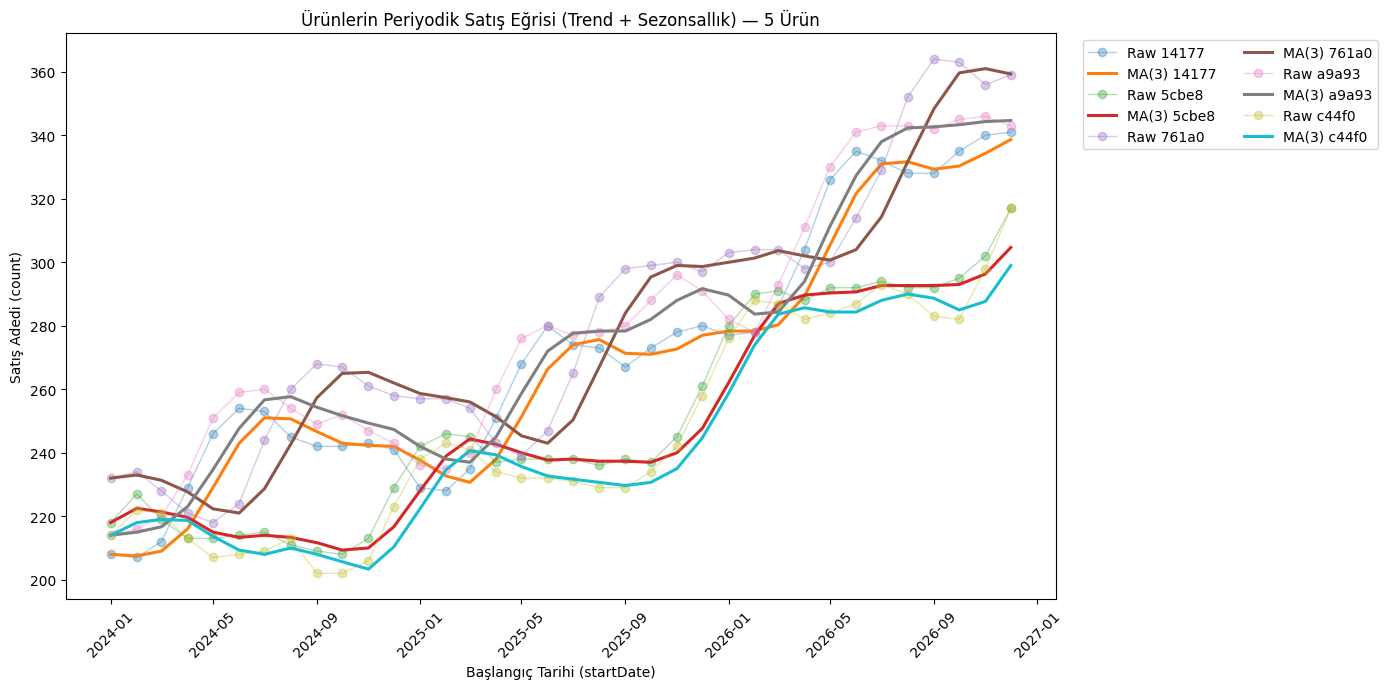

In [42]:
# H6 — Tüm ürünler tek grafikte (Raw + MA)
import matplotlib.pyplot as plt
# %matplotlib inline   # (opsiyonel, Jupyter için)

plt.figure(figsize=(14, 7))

for product_id in df['productId'].unique():
    product_df = df[df['productId'] == product_id]
    # Ham seri
    plt.plot(product_df['startDate'], product_df['count'], marker='o', linewidth=1, alpha=0.35, label=f'Raw {product_id[:5]}')
    # MA(3)
    plt.plot(product_df['startDate'], product_df['ma3'], linewidth=2.2, label=f'MA(3) {product_id[:5]}')

plt.xlabel("Başlangıç Tarihi (startDate)")
plt.ylabel("Satış Adedi (count)")
n_products = df["productId"].nunique()
plt.title(f"Ürünlerin Periyodik Satış Eğrisi (Trend + Sezonsallık) — {n_products} Ürün")
plt.xticks(rotation=45)
plt.legend(ncol=2, bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()

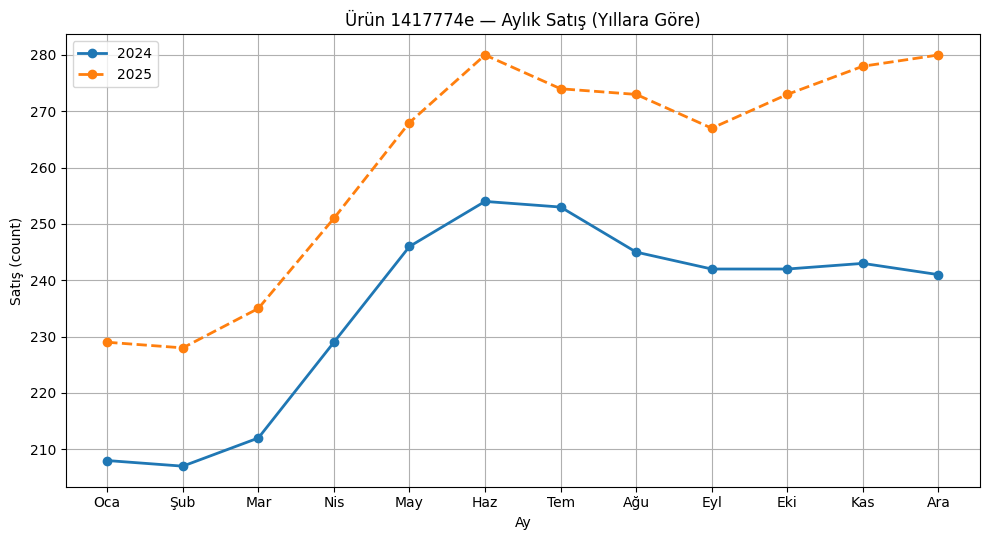

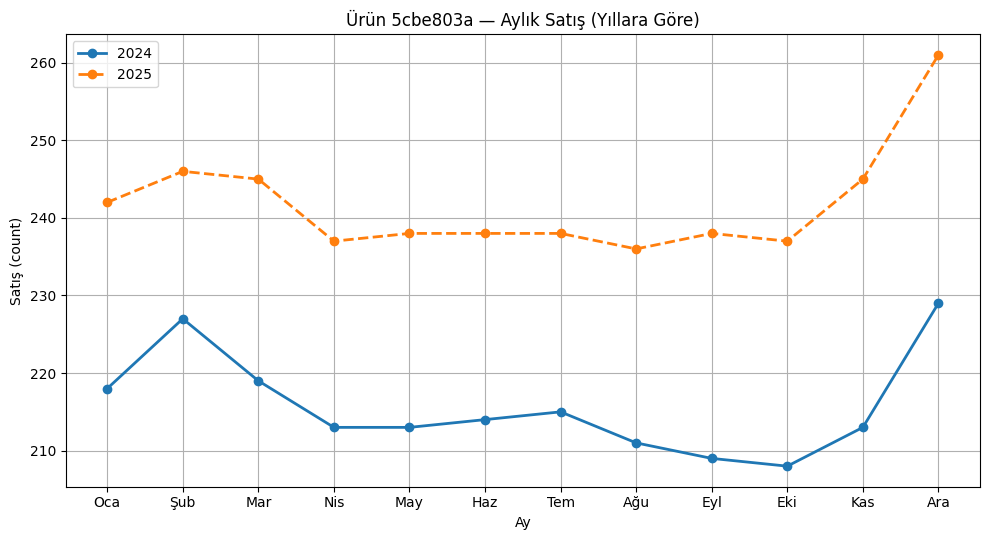

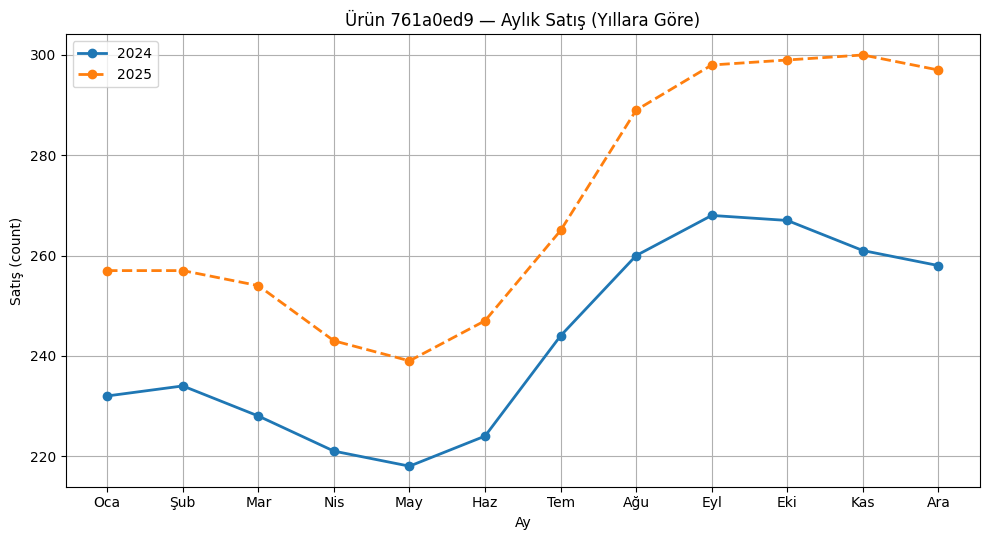

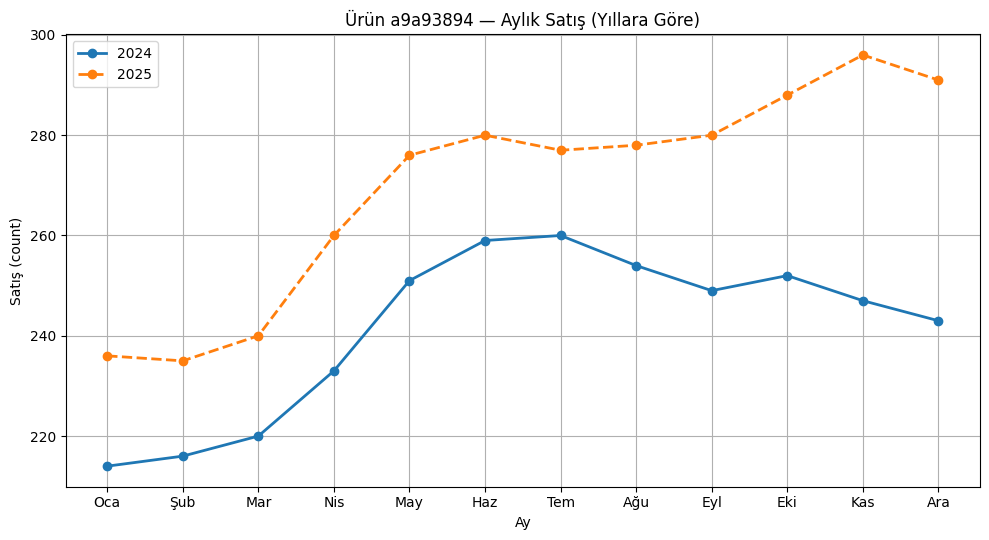

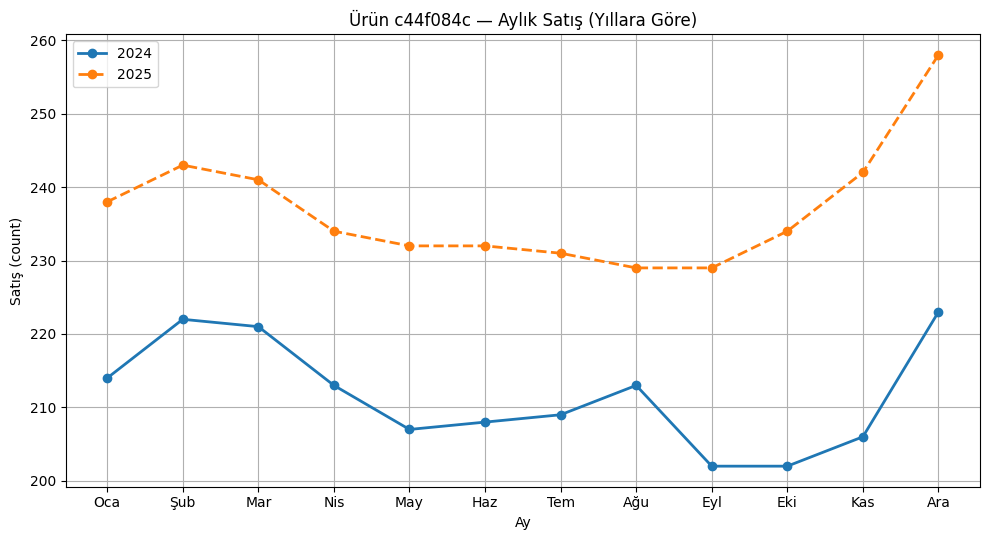

In [44]:
# H7 — Yıllara göre iki çizgi (ürün başına: 2024/2025/2026)
df["year"]  = df["startDate"].dt.year
df["month"] = df["startDate"].dt.month

aylar = list(range(1, 13))
ay_etiket = ["Oca","Şub","Mar","Nis","May","Haz","Tem","Ağu","Eyl","Eki","Kas","Ara"]

for pid in df["productId"].unique():
    sub = df[df["productId"] == pid].copy()
    pivot = sub.pivot_table(index="month", columns="year", values="count", aggfunc="sum").reindex(aylar)

    plt.figure(figsize=(10, 5.5))
    # 2024 düz çizgi
    if 2024 in pivot.columns:
        plt.plot(aylar, pivot[2024].values, marker='o', linewidth=2, label='2024')
    # 2025 kesikli çizgi
    if 2025 in pivot.columns:
        plt.plot(aylar, pivot[2025].values, marker='o', linewidth=2, linestyle='--', label='2025')

    plt.title(f"Ürün {pid[:8]} — Aylık Satış (Yıllara Göre)")
    plt.xlabel("Ay"); plt.ylabel("Satış (count)")
    plt.xticks(aylar, ay_etiket)
    plt.legend(loc="upper left")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [45]:
# H8 — Özet istatistikler ve aydan aya değişim (MoM %)
tmp = df.sort_values(["productId","startDate"]).copy()
tmp["mom_change"] = tmp.groupby("productId")["count"].pct_change()*100

print("Özet (count):")
print(tmp["count"].describe().round(2))
print("\nAydan aya değişim (%) — istatistikler:")
print(tmp["mom_change"].describe().round(2))


Özet (count):
count    180.00
mean     265.39
std       40.81
min      202.00
25%      234.00
50%      258.50
75%      292.00
max      364.00
Name: count, dtype: float64

Aydan aya değişim (%) — istatistikler:
count    175.00
mean       1.30
std        3.15
min       -5.16
25%       -0.85
50%        0.42
75%        3.10
max        9.06
Name: mom_change, dtype: float64


In [48]:
# H9 — CSV kaydı (ham şema: productId, startDate, endDate, count)
df[["productId","startDate","endDate","count"]].to_csv('product-data.csv', index=False)
print("Kaydedildi: product-data.csv")

Kaydedildi: product-data.csv


In [50]:
# H10 — JSON kaydı (ham şema, array of objects)
import json
import pandas as pd  # kernel reset olduysa gerekebilir

with open("product-data.json", "w", encoding="utf-8") as f:
    json.dump(
        df[["productId","startDate","endDate","count"]]
          .assign(
              startDate=lambda d: d["startDate"].dt.strftime("%Y-%m-%d"),
              endDate=lambda d: pd.to_datetime(d["endDate"]).dt.strftime("%Y-%m-%d")
          )
          .to_dict("records"),
        f,
        ensure_ascii=False,
        indent=2
    )
print("Kaydedildi: product-data.json")


Kaydedildi: product-data.json


In [52]:
# H11B — Seasonal-naive + drift (trend düzeltmeli) TAHMİN
d = df.copy()
d["year"]  = d["startDate"].dt.year
d["month"] = d["startDate"].dt.month

train = d.query("year <= 2025").copy()
test  = d.query("year == 2026").copy()

y25 = train.query("year == 2025")[["productId","month","count"]].rename(columns={"count":"y25"})
y24 = train.query("year == 2024")[["productId","month","count"]].rename(columns={"count":"y24"})

ref = y25.merge(y24, on=["productId","month"], how="left")
ref["y_pred_drift"] = 2*ref["y25"] - ref["y24"]

fc_drift = (test[["productId","startDate","endDate","month","count"]]
            .rename(columns={"count":"y_true"})
            .merge(ref[["productId","month","y_pred_drift"]], on=["productId","month"], how="left")
           )

# Eksikler için ileri/geri doldur (ürün bazında)
fc_drift = fc_drift.sort_values(["productId","month","startDate"]).reset_index(drop=True)
fc_drift["y_pred_drift"] = fc_drift.groupby("productId")["y_pred_drift"].transform(lambda s: s.ffill().bfill())


In [54]:
# H12A — fc_drift -> fc adaptörü (her koşuda fc üret)
assert "fc_drift" in globals(), "Önce H11 (fc_drift) hücrelerini çalıştır."
_need = {"productId","startDate","endDate","y_true","y_pred_drift"}
missing = _need - set(fc_drift.columns)
assert not missing, f"fc_drift kolon eksik: {missing}"

fc = (fc_drift[["productId","startDate","endDate","y_true","y_pred_drift"]]
      .rename(columns={"y_pred_drift":"y_pred"})
      .copy())
fc[["y_true","y_pred"]] = fc[["y_true","y_pred"]].apply(pd.to_numeric, errors="coerce")
fc["y_pred"] = fc["y_pred"].clip(lower=0)

In [56]:
# H12B (guard'lı)
from math import sqrt
from IPython.display import display

if "fc" not in globals():
    assert "fc_drift" in globals(), "Önce H11'i çalıştır (fc_drift lazım)."
    fc = (fc_drift[["productId","startDate","endDate","y_true","y_pred_drift"]]
          .rename(columns={"y_pred_drift":"y_pred"})
          .copy())
    fc[["y_true","y_pred"]] = fc[["y_true","y_pred"]].apply(pd.to_numeric, errors="coerce")
    fc["y_pred"] = fc["y_pred"].clip(lower=0)

fc_eval = fc.copy()
fc_eval["err"]   = fc_eval["y_pred"] - fc_eval["y_true"]
fc_eval["ae"]    = fc_eval["err"].abs()
fc_eval["se"]    = fc_eval["err"]**2
fc_eval["ape"]   = (fc_eval["ae"] / fc_eval["y_true"].replace(0, np.nan)) * 100
fc_eval["smape"] = 100 * (fc_eval["ae"] / ((fc_eval["y_true"].abs() + fc_eval["y_pred"].abs())/2).replace(0, np.nan))

cols = ["ae","se","ape","smape"]

def summarize_from_cols(g):
    mae   = g["ae"].mean()
    rmse  = sqrt(g["se"].mean())
    mape  = g["ape"].mean(skipna=True)
    smape = g["smape"].mean(skipna=True)
    return pd.Series({"MAE": round(mae,2), "RMSE": round(rmse,2),
                      "MAPE(%)": round(mape,2), "sMAPE(%)": round(smape,2)})

by_prod = (fc_eval.groupby("productId", group_keys=False)[cols]
           .apply(summarize_from_cols))
overall = summarize_from_cols(fc_eval[cols])

print("=== METRİKLER (ürün bazında) ===")
display(by_prod)
print("\n=== GENEL ===")
print(overall)


=== METRİKLER (ürün bazında) ===


,MAE,RMSE,MAPE(%),sMAPE(%)
productId,,,,
1417774e-7849-44a7-ba39-92a6dbcc7c5d,30.00,30.30,9.49,9.97
5cbe803a-e269-4cac-b2f0-35dac7b33927,26.00,26.47,8.85,9.27
761a0ed9-4a8f-48cf-8c3c-4eeef407c6d3,30.92,32.09,9.48,10.00
a9a93894-8e72-4229-8d8f-e88c63f2d83e,26.75,29.94,8.29,8.74
c44f084c-f567-4b03-8a72-5bca900933e4,26.75,28.07,9.25,9.75



=== GENEL ===
MAE         28.08
RMSE        29.44
MAPE(%)      9.07
sMAPE(%)     9.55
dtype: float64


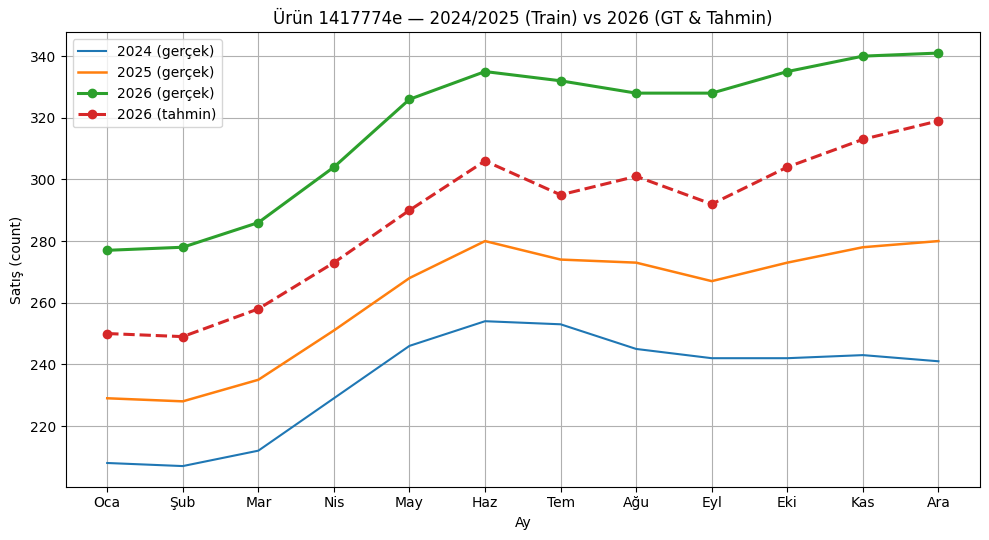

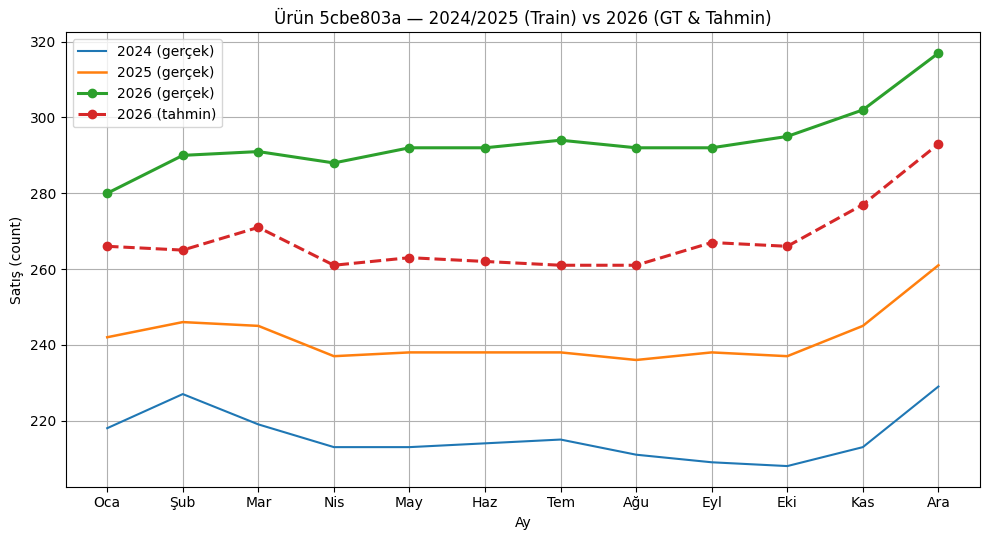

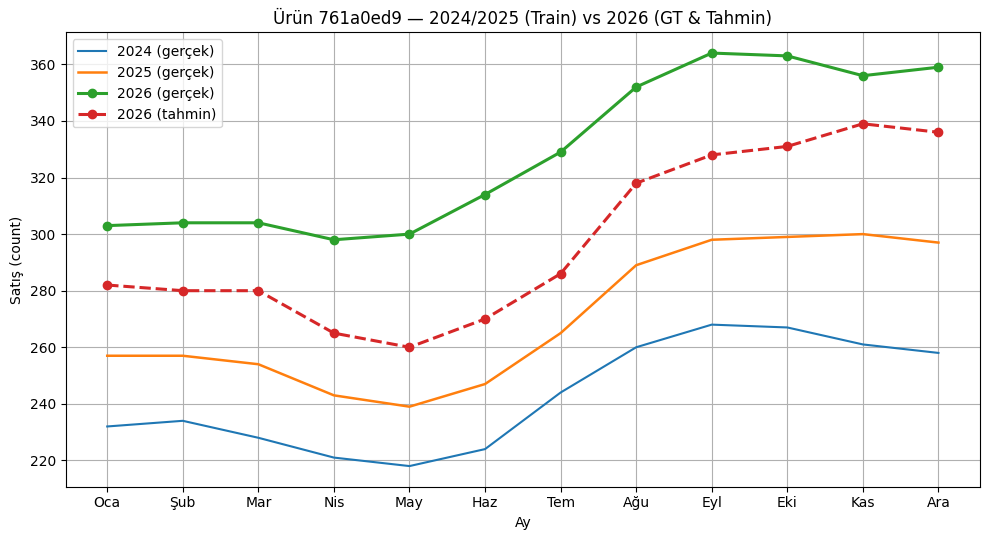

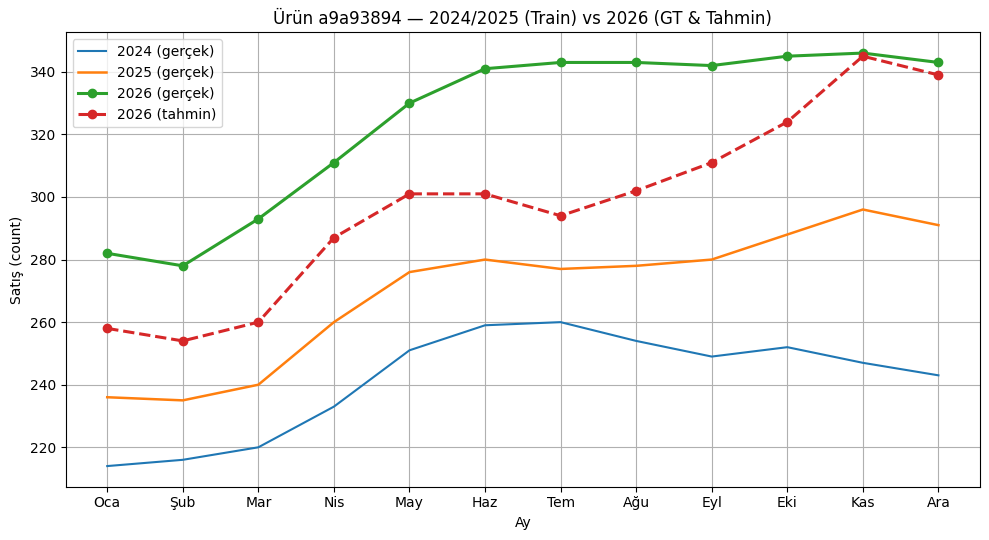

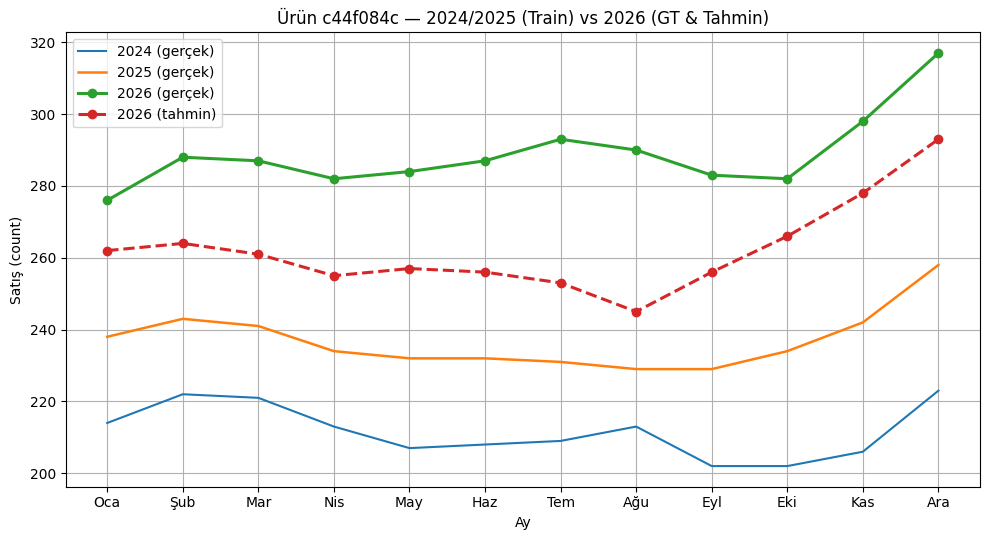

In [58]:
# H13 — 2024/2025 (gerçek) + 2026 (gerçek) + 2026 (tahmin) grafiği [sağlam sürüm]

from IPython.display import display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1) HANGİ TAHMİNİ KULLANACAĞINI SEÇ
# forecast = fc          # -> seasonal-naive (H12A/B'de oluşmuş olmalı)
# forecast = fc_drift    # -> seasonal-naive + drift
# forecast = fc_ma       # -> 2 yıllık mevsimsel ortalama
forecast = fc  # mevcut seçimi korudum

# 2) TAHMİN KOLONUNU OTOMATİK BUL (y_pred, y_pred_drift, y_pred_ma…)
pred_cols = [c for c in forecast.columns if c.startswith("y_pred")]
assert len(pred_cols) >= 1, "Tahmin kolonu bulunamadı (y_pred*). H11/H12 çalıştı mı?"
PRED_COL = pred_cols[0]
PRED_LABEL = PRED_COL.replace("y_pred", "tahmin").strip("_")

# 3) forecast içinde tarih -> year/month türet (yoksa)
f = forecast.copy()
if "startDate" in f.columns:
    f["startDate"] = pd.to_datetime(f["startDate"])
else:
    # bazı türevlerde 'ds' olabilir; gerekirse uyarlayın
    raise KeyError("forecast['startDate'] yok. H11/H12 akışını kontrol edin.")

if "month" not in f.columns:
    f["month"] = f["startDate"].dt.month
if "year" not in f.columns:
    f["year"] = f["startDate"].dt.year

# 4) Görselleştirme
ay_etiket = ["Oca","Şub","Mar","Nis","May","Haz","Tem","Ağu","Eyl","Eki","Kas","Ara"]

d = df.copy()
d["year"]  = d["startDate"].dt.year
d["month"] = d["startDate"].dt.month

for pid in d["productId"].unique():
    g = d[d["productId"]==pid].copy()
    piv_24 = g[g["year"]==2024].set_index("month")["count"].reindex(range(1,13))
    piv_25 = g[g["year"]==2025].set_index("month")["count"].reindex(range(1,13))
    piv_26 = g[g["year"]==2026].set_index("month")["count"].reindex(range(1,13))

    # Tahmin (2026 ayları) — forecast içinde ilgili productId ve 2026 süz
    pred_26 = (f[(f["productId"]==pid) & (f["year"]==2026)]
                 .set_index("month")[PRED_COL]
                 .reindex(range(1,13)))

    plt.figure(figsize=(10,5.5))
    if piv_24.notna().any(): plt.plot(range(1,13), piv_24.values, label="2024 (gerçek)", linewidth=1.5)
    if piv_25.notna().any(): plt.plot(range(1,13), piv_25.values, label="2025 (gerçek)", linewidth=1.8)
    if piv_26.notna().any(): plt.plot(range(1,13), piv_26.values, label="2026 (gerçek)", linewidth=2.2, marker='o')

    # Tahmin çizgisi
    if pred_26.notna().any():
        plt.plot(range(1,13), pred_26.values, label=f"2026 ({PRED_LABEL})",
                 linewidth=2.2, linestyle="--", marker="o")

    plt.title(f"Ürün {pid[:8]} — 2024/2025 (Train) vs 2026 (GT & Tahmin)")
    plt.xlabel("Ay"); plt.ylabel("Satış (count)")
    plt.xticks(range(1,13), ay_etiket)
    plt.legend(loc="upper left"); plt.grid(True)
    plt.tight_layout(); plt.show()


In [60]:
# H14 — Tahmin sonuçlarını kaydet (CSV + JSON)  [Tarihleri ISO stringe çevirir]

import json
import pandas as pd

# --- 0) Forecast DF'ini akıllıca seç (fc yoksa fc_drift / fc_ma) ---
def _pick_forecast():
    # Tercih sırası: fc > fc_drift > fc_ma
    if "fc" in globals():
        return fc.copy(), "base"
    if "fc_drift" in globals():
        x = fc_drift.copy()
        if "y_pred_drift" in x.columns:
            x = x.rename(columns={"y_pred_drift": "y_pred"})
        return x, "drift"
    if "fc_ma" in globals():
        x = fc_ma.copy()
        if "y_pred_ma" in x.columns:
            x = x.rename(columns={"y_pred_ma": "y_pred"})
        return x, "ma"
    raise RuntimeError("Hiçbir forecast DF bulunamadı (fc / fc_drift / fc_ma). H11/H12 adımlarını çalıştır.")

forecast, method_tag = _pick_forecast()

# --- 1) Tahmin kolonunu otomatik bul (y_pred*, örn. y_pred / y_pred_drift / y_pred_ma) ---
pred_cols = [c for c in forecast.columns if c.startswith("y_pred")]
assert len(pred_cols) >= 1, "Tahmin kolonu (y_pred*) bulunamadı. H11/H12 çalıştı mı?"
PRED_COL = pred_cols[0]

# --- 2) Zorunlu kolon kontrolü ve kopya ---
need = {"productId", "startDate", "endDate", "y_true", PRED_COL}
missing = need - set(forecast.columns)
assert not missing, f"Eksik kolon(lar): {missing}"
out_df = forecast[list(need)].copy()

# --- 3) Tarihler: sırala + ISO stringe çevir ---
out_df["startDate"] = pd.to_datetime(out_df["startDate"])
out_df["endDate"]   = pd.to_datetime(out_df["endDate"])
out_df = out_df.sort_values(["productId","startDate"]).reset_index(drop=True)

# çıktı kolon adını 'y_pred' yap
out_df = out_df.rename(columns={PRED_COL: "y_pred"})

# ISO format string
out_df["startDate"] = out_df["startDate"].dt.strftime("%Y-%m-%d")
out_df["endDate"]   = out_df["endDate"].dt.strftime("%Y-%m-%d")

# --- 4) Dosya adlarını dinamik üret (metoda göre) ---
# Veri içindeki tarih aralığını dosya adına yansıt
try:
    yrs = pd.to_datetime(out_df["startDate"]).dt.year
    year_span = f"{yrs.min()}-{yrs.max()}"
except Exception:
    year_span = "range"

suffix = {"base":"seasonal-naive", "drift":"drift", "ma":"ma"}.get(method_tag, method_tag)
csv_name  = f"forecast_{year_span}_{suffix}.csv"
json_name = f"forecast_{year_span}_{suffix}.json"

# --- 5) Kaydet ---
out_df.to_csv(csv_name, index=False, encoding="utf-8")
with open(json_name, "w", encoding="utf-8") as f:
    json.dump(out_df.to_dict("records"), f, ensure_ascii=False, indent=2)

print("Kaydedildi:", csv_name, "ve", json_name)

Kaydedildi: forecast_2026-2026_seasonal-naive.csv ve forecast_2026-2026_seasonal-naive.json
